# Avskoging
Denne notebooking trener en modell for avskoging. Modellen skal predikere om det har skjedd avskoging.


In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from fastai.vision.all import *
from fastcore.foundation import L
from pathlib import Path
import pickle
import shapely
import rasterio.features
from pathlib import Path

Pathen til dataen

In [2]:
image_root = Path("/kaggle/input/forest/deep/downloads/ForestNetDataset")

Åpner opp de ulike csv-filene

In [3]:
train = pd.read_csv(image_root / "train.csv")
test = pd.read_csv(image_root / "test.csv")

Vi ser på head for å vite hva slags data vi har

In [4]:
train.head()


,label,merged_label,latitude,longitude,year,example_path
0,Timber plantation,Plantation,4.430849,96.101634,2014,examples/4.430849118860583_96.1016343478138
1,Other,Other,1.332341,109.374229,2012,examples/1.3323406178609702_109.37422873130464
2,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,examples/-1.720266384577504_115.00699582064485
3,Small-scale agriculture,Smallholder agriculture,-2.248346,104.135786,2011,examples/-2.248346072674411_104.1357857482906
4,Other large-scale plantations,Plantation,-2.100800,113.022376,2008,examples/-2.100800102991412_113.0223763234016


Her ser vi at modellen gir noen labels som forteller hva landområdet er brukt til, kordinatene til området og året det ble avskoget. De gir også pathen til dataen.

Ser vi hva som finnes i mappene, ser vi at det finnes to bilder, et infrarødt og et synelig. Disse blir vår input. Labelet er lagret som en .pkl fil. I tilegg til disse finnes det ekstra metadata. Ettersom datasettet er lite beskrevet, er det vanskelig å vite hva enkelt data betyr. Derfor har disse ikke blit brukt.

## Datablock
Når vi lager en datablock, må vi vite hvordan vi skal hente ut data.

Det synelige bildet henter vi bare med å sende lenken .

In [5]:
def get_visible_image(item):
    png_image_path = image_root / item['example_path'] / "images/visible/composite.png"
    return png_image_path

Det infrarødet må endres fra en np array til et bildet for at det skal kunne brukes.

In [6]:
def get_infrared_image(item):
    numpy_image_path = image_root / item['example_path'] / "/images/infrared/composite.npy"
    numpy_input_array = np.load(numpy_image_path)
    numpy_converted_array = (numpy_input_array >> 8).astype(np.uint8)
    numpy_image = Image.fromarray(numpy_converted_array.reshape((332,332,3)))
    return numpy_image

Maksen er i dette tilfellet bare en polygon. Den er lagret som en .pkl-fil. Vi åpner pkl-filen og får ut et objekt. Objektet som kommer ut er et polygon objekt, altså kanten rundt området. Dette må gjøres om til en maske. Dette kan gjøres ved hjelp av rasrerio. Den gir oss en nparray som så kan gjøres om til et bilde.

In [7]:
def get_mask(item):
    mask_path = image_root / item['example_path'] / "forest_loss_region.pkl"
    with open(mask_path, 'rb') as f:
        data = pickle.load(f)
        img = rasterio.features.rasterize([data], out_shape=(332, 332))
        return Image.fromarray(img)    

Vi lager en datablock. Det ble prøvd å få modellen til å ta imot både det normale og det infrarøde bildet, men dette hadde vi problemer med. Det ble bare det synelige. Muligheter for mer input har blit utforsket, men ikke kommet helt i mål.

Vi hiver også inn en aug_transfoms(). Vi bruker bare standardverdien.

In [8]:
block = DataBlock(blocks=(ImageBlock, MaskBlock),
                  get_x=get_visible_image,
                  get_y=get_mask,
                  item_tfms=Resize(224),
                  batch_tfms=aug_transforms(),
                  splitter=RandomSplitter(valid_pct=0.2, seed=42))

Lager en datablock med batch size 16. 

In [9]:
dls = block.dataloaders(train, bs=32)

Bildene ser greie ut. Kan legge til at vi ikke klarer å skille hvor det er ny avskoging, og hva som allerede er avskoget. Det kan hende at vi ikke har oppfattet hvordan datasette fungerer på riktig måte. Det ser fremdeles ut som en del av masken følger markeringer i landskapet, noe som tyder på at det er riktig maske.

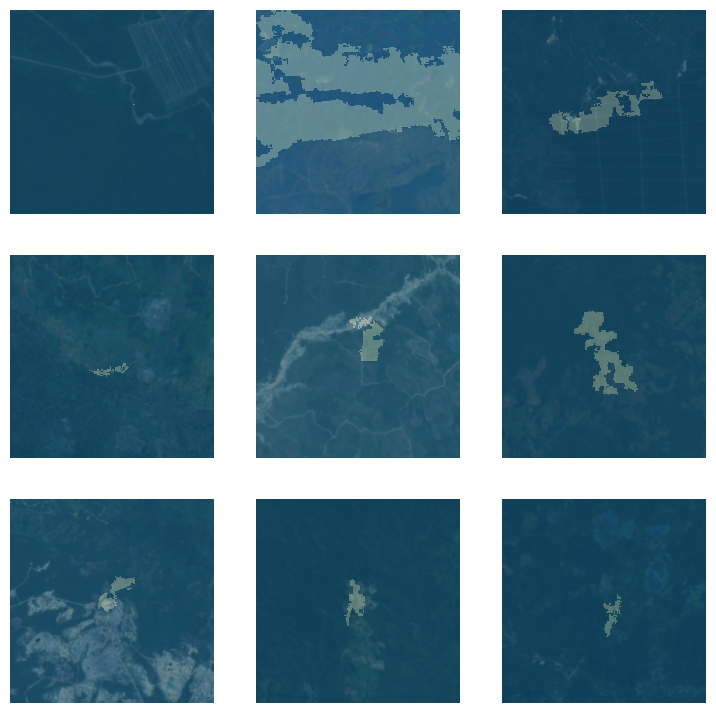

In [10]:
dls.show_batch()

Lager en learner. Vi bruker metrics Dice. Den måler overlappet mellom prediksjonen og faktisk masken. 

In [11]:
learn = unet_learner(dls, resnet34, metrics=Dice, self_attention=True, act_cls=Mish, n_out=2)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,dice,time
0,0.219766,0.538166,0.000000,00:36


epoch,train_loss,valid_loss,dice,time
0,0.163610,0.143770,0.000010,00:32
1,0.153985,0.134364,0.000000,00:31
2,0.147178,0.137219,0.000000,00:31
3,0.140452,0.121231,0.000000,00:31
4,0.134436,0.132156,0.115434,00:32
5,0.126408,0.120212,0.000000,00:32
6,0.119756,0.121361,0.000000,00:32
7,0.112128,0.120554,0.009663,00:31
8,0.105967,0.123858,0.046714,00:32
9,0.098044,0.122816,0.264154,00:31


Etter å ha fine tunet modelle får vi en dice-score på 0.27. Dette er ikke en serlig høy score, men viser at modellen er bedre en tilfeldig data. Det demonsterer også at det er mulig å bruke en slik modell til å gjøre noe av arbeidet med å finne avskogede områder.

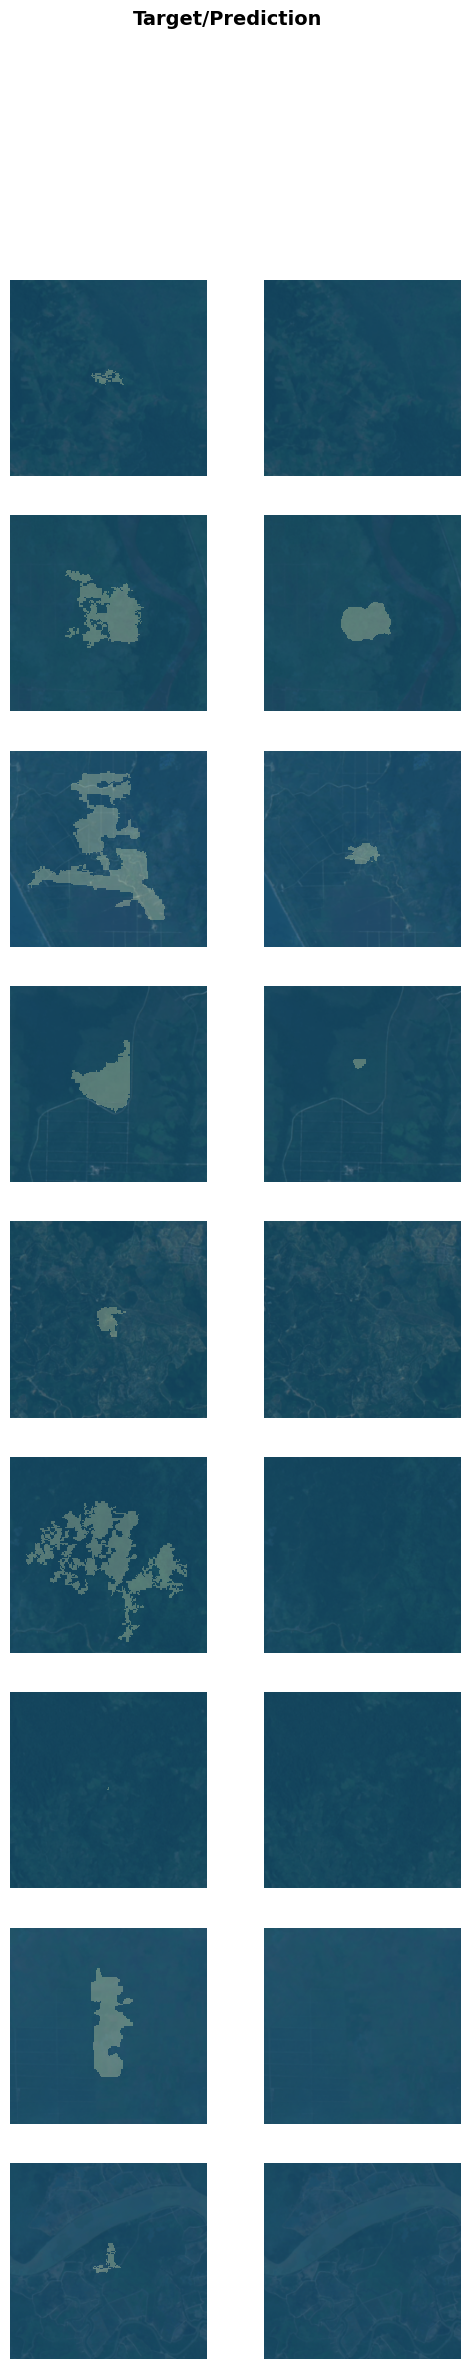

In [14]:
learn.show_results()

Ser vi på eksemplene over, ser vi at den har en del manger, og finner ikke de fleste områdene. Metadaten som ble eksludert og de infrarøde bildene kunne ha vært med på å gjøre modellen bedre. Det kan være flere teknikker som kunne ha gjort modellen bedre. Blant annet sett om en kunne ha gjort noe med loss-funksjonen. Hva som er målet vil påvirke dette. Om målet er å finne mengden avskoging eller plassen der det er avskoget, påvirker hvordan en vi gå frem. 